<a href="https://www.kaggle.com/code/amirmotefaker/titanic-machine-learning-from-disaster?scriptVersionId=177807019" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from IPython.display import display

def display_tab(df):
    display(df.head(7))
    print("DataFrame shape: {}".format(df.shape))

In [2]:
df = pd.read_csv("/kaggle/input/titanic/train.csv")
display_tab(df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


DataFrame shape: (891, 12)


In [3]:
display(df.isnull().sum().sort_values(ascending=False))
df.describe(include='all')

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:
titanic = df.copy()

In [5]:
# Dropping and removing NaN values
titanic = titanic.drop(['PassengerId','Ticket','Cabin'], axis=1)
titanic = titanic.dropna()

In [6]:
# Transforming categorical values
titanic['Survived'] = titanic['Survived'].map({1: 'Survived', 0: 'Died'})
titanic['Pclass'] = titanic['Pclass'].map({1: 'First', 2: 'Second', 3: 'Third'})

In [7]:
display_tab(titanic)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,Died,Third,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,Survived,First,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,Survived,Third,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,Survived,First,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,Died,Third,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S
6,Died,First,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S
7,Died,Third,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S


DataFrame shape: (712, 9)


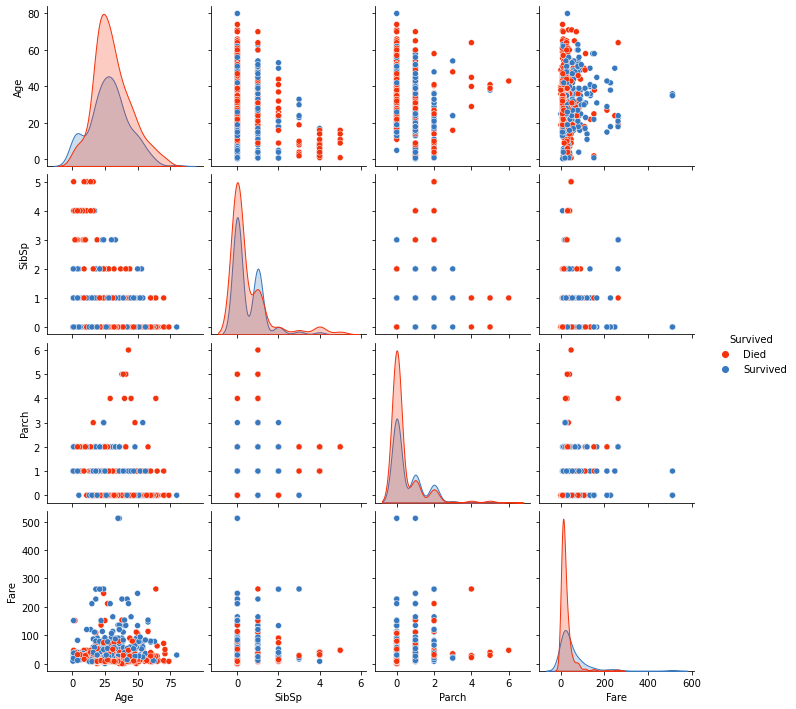

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

colors = ["vermillion", "windows blue", "leaf green", "iris", "amber", "greyish"]
sns.set_palette(sns.xkcd_palette(colors))

display(sns.pairplot(titanic, hue='Survived'))

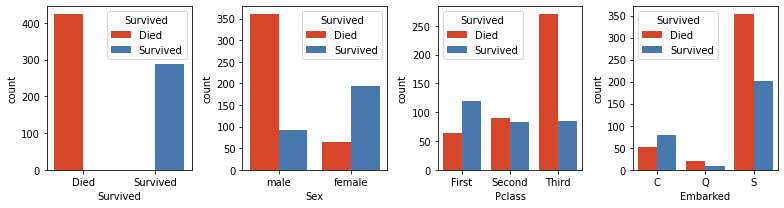

In [9]:
category_label = ['Survived', 'Sex', 'Pclass', 'Embarked']
category_order = [['Died', 'Survived'], ['male', 'female'], 
                  ['First', 'Second', 'Third'], ['C', 'Q', 'S']]

fig, axes = plt.subplots(1, 4, figsize=(11,3))

for ax, x, order in zip(axes, category_label, category_order):
    sns.countplot(x=x, order=order, hue='Survived', data=titanic, ax=ax)

fig.tight_layout()

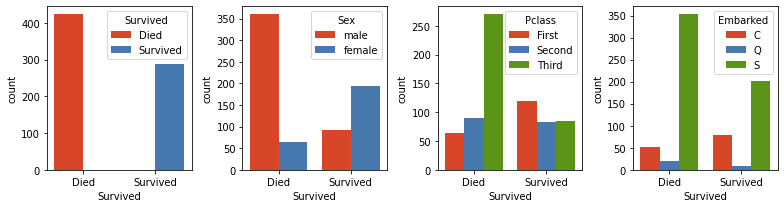

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(11,3))

for ax, x, order in zip(axes, category_label, category_order):
    sns.countplot(x='Survived', hue=x, hue_order=order, data=titanic, ax=ax)

fig.tight_layout()

### Supervised Machine Learning

In [11]:
# module imports
from patsy import dmatrices
import statsmodels.discrete.discrete_model as sm

# create matrices
#formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)'
#y, X = dmatrices(formula, df, return_type = 'dataframe')

formulas = ['Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)',
            'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare',
            'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Embarked)',
            'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Fare + C(Embarked)',
            'Survived ~ C(Pclass) + C(Sex) + Age + Parch + Fare + C(Embarked)']
models = []

for formula in formulas:
    y, X = dmatrices(formula, df, return_type = 'dataframe')
    logit = sm.Logit(y, X)
    model = logit.fit()
    print('Formula: {}\n{}\n'.format(formula, model.params))
    models.append(model)

Optimization terminated successfully.
         Current function value: 0.444060
         Iterations 6
Formula: Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)
Intercept           4.432931
C(Pclass)[T.2]     -1.189637
C(Pclass)[T.3]     -2.395220
C(Sex)[T.male]     -2.637859
C(Embarked)[T.Q]   -0.823379
C(Embarked)[T.S]   -0.402848
Age                -0.043308
SibSp              -0.362925
Parch              -0.060365
Fare                0.001451
dtype: float64

Optimization terminated successfully.
         Current function value: 0.445221
         Iterations 6
Formula: Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare
Intercept         4.179995
C(Pclass)[T.2]   -1.292538
C(Pclass)[T.3]   -2.501069
C(Sex)[T.male]   -2.637451
Age              -0.044159
SibSp            -0.376847
Parch            -0.061268
Fare              0.002043
dtype: float64

Optimization terminated successfully.
         Current function value: 0.444291
         Iterations 6
Formul

In [12]:
tdf = pd.read_csv("/kaggle/input/titanic/test.csv")
tdf.fillna(tdf.mean(), inplace=True)
tdf['Survived'] = 0.5
display_tab(tdf)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.5
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.5
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.5
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.5
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.5
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.5
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0.5


DataFrame shape: (418, 12)


In [13]:
def submission(df, filename="submission.csv", path = "/kaggle/working/"):
    res = df[['PassengerId', 'Survived']].copy()
    res = res.round({'Survived': 0})
    res = res.astype({'Survived': int})
    res.to_csv(path + filename, index=False)

In [14]:
for i, (formula, model) in enumerate(zip(formulas, models)):
    yt, Xt = dmatrices(formula, tdf, return_type='dataframe')
    y_pred = model.predict(Xt)
    tdf['Survived'] = y_pred
    submission(tdf, "{}_logit_regression_submission.csv".format(i+1))

In [15]:
from sklearn.linear_model import LogisticRegression
# sklearn output
model = LogisticRegression(solver='liblinear', fit_intercept = False, C = 1e9)
mdl = model.fit(X, y.values.ravel())
#display(model.coef_)

y_pred = mdl.predict(Xt)

tdf['Survived'] = y_pred
display_tab(tdf)

submission(tdf, "sk_logit_regression_submission.csv")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0.0


DataFrame shape: (418, 12)


## scikit-learn classifiers

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import numpy as np

In [17]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear"),
    SVC(kernel="rbf"),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()]

In [18]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)'
y, X = dmatrices(formula, df, return_type = 'dataframe')
y = y.values.ravel()

accuracies = []

for name, clf in zip(names, classifiers):
    # Training
    clf.fit(X, y)
    # Testing
    pred = clf.predict(X)
    accuracy = accuracy_score(y, pred) * 100
    accuracies.append(accuracy)
    # [example] Accuracy for [model]: [Accuracy]
    print('Accuracy for {}: {}'
          .format(name, accuracy))

Accuracy for Nearest Neighbors: 82.4438202247191
Accuracy for Linear SVM: 77.9494382022472
Accuracy for RBF SVM: 67.2752808988764


/opt/conda/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Accuracy for Gaussian Process: 78.93258426966293
Accuracy for Decision Tree: 98.59550561797754
Accuracy for Random Forest: 98.59550561797754


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Accuracy for Neural Net: 81.03932584269663
Accuracy for AdaBoost: 82.86516853932584
Accuracy for Naive Bayes: 78.65168539325843


In [19]:
for i, (name, clf) in enumerate(zip(names, classifiers)):
    yt, Xt = dmatrices(formula, tdf, return_type='dataframe')
    pred = clf.predict(Xt)
    print(name)
    tdf['Survived'] = pred
    display_tab(tdf)
    submission(tdf, "{}_{}_submission.csv".format(i+1, name))

Nearest Neighbors


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0.0


DataFrame shape: (418, 12)
Linear SVM


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1.0


DataFrame shape: (418, 12)
RBF SVM


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0.0


DataFrame shape: (418, 12)
Gaussian Process


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1.0


DataFrame shape: (418, 12)
Decision Tree


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0.0


DataFrame shape: (418, 12)
Random Forest


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0.0


DataFrame shape: (418, 12)
Neural Net


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1.0


DataFrame shape: (418, 12)
AdaBoost


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1.0


DataFrame shape: (418, 12)
Naive Bayes


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0.0


DataFrame shape: (418, 12)
